# Data Preparation and Explorative Analysis Workbook

## Import libraries and modules

In [1]:
import pandas as pd
import html
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from textblob import TextBlob
from wordcloud import WordCloud
import re
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


## 1 - Data Cleaning - PIPELINE

In [2]:
# Read in the training data
train_df = pd.read_json('./data/lewtun-drug-reviews/train.jsonl', lines=True)
train_df.sample(5)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
43186,93004,Vortioxetine,Major Depressive Disorde,"""Only on day 3, but so far so good. I read up ...",8,2016-09-21,21
53875,123447,Apri,Birth Control,"""I was previously on Yaz both for birth contro...",9,2010-03-17,30
101960,128045,Phentermine,Weight Loss,"""I&#039;ve just started taking this pill a wee...",9,2016-07-27,34
144187,51405,Azithromycin,Bronchitis,"""I did the Tri-pak actually. That&#039;s three...",10,2012-05-05,16
1455,20113,Macrobid,Urinary Tract Infection,"""When taking macrobid I felt slightly nauseous...",6,2016-07-02,11


In [3]:
# Check for data types and missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   161297 non-null  int64         
 1   drugName     161297 non-null  object        
 2   condition    160398 non-null  object        
 3   review       161297 non-null  object        
 4   rating       161297 non-null  int64         
 5   date         161297 non-null  datetime64[ns]
 6   usefulCount  161297 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 8.6+ MB


In [4]:
# Check for duplicated id
train_df.duplicated(subset=['Unnamed: 0']).sum()

0

In [5]:
# Decode HTML entities back to original characters and remove whitespaces
train_df['review'] = train_df['review'].apply(html.unescape).str.replace(r'[\r\n\t]', '', regex=True).str.strip()
#train_df['condition'] = train_df['condition'].apply(lambda x: html.unescape(x) if x is not None else None)

In [6]:
# Check out wrong condition values
train_df[train_df.condition.notna() & train_df.condition.str.contains('users found this comment helpful')]

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
105,220696,Loestrin 24 Fe,2</span> users found this comment helpful.,"""I'm 16 and I have been on Loestrin 24 for ab...",3,2010-11-03,2
196,67383,Provera,4</span> users found this comment helpful.,"""I'm 24 years old and have always had a pretty...",1,2016-03-27,4
243,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,2010-06-01,3
264,132965,Loestrin 24 Fe,4</span> users found this comment helpful.,"""Took this pill for 1.) Acne and 2.) Birth Con...",2,2014-06-24,4
391,91050,Norco,11</span> users found this comment helpful.,"""I have suffered with low back pain - 2 surger...",9,2009-03-15,11
...,...,...,...,...,...,...,...
160322,173464,Alli,99</span> users found this comment helpful.,"""Great pill... You can definitely see it worki...",9,2015-04-02,99
160791,150010,Soma,62</span> users found this comment helpful.,"""I am sharing a painful experience actually. T...",5,2010-03-11,62
160899,209239,Geodon,7</span> users found this comment helpful.,"""I've been taking Geodon for about a month or ...",7,2011-02-04,7
160921,96527,Neurontin,92</span> users found this comment helpful.,"""At 300mg 4x daily my pain was almost gone. """,9,2013-07-08,92


In [7]:
# Remove wrong condition values and keep the rows
train_df.loc[train_df.condition.notna() & train_df.condition.str.contains('users found this comment helpful'), 'condition'] = None

In [8]:
# Check out rows with missing condition values
train_df[train_df.condition.isna()]

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
30,51452,Azithromycin,None,"""Very good response. It is so useful for me. """,10,2010-08-18,1
105,220696,Loestrin 24 Fe,None,"""I'm 16 and I have been on Loestrin 24 for ab...",3,2010-11-03,2
148,61073,Urea,None,"""Accurate information.""",10,2011-07-02,13
196,67383,Provera,None,"""I'm 24 years old and have always had a pretty...",1,2016-03-27,4
243,81588,Yaz,None,"""I took Yaz for a little over 2 years. From a...",3,2010-06-01,3
...,...,...,...,...,...,...,...
160791,150010,Soma,None,"""I am sharing a painful experience actually. T...",5,2010-03-11,62
160841,150516,Sulfamethoxazole / trimethoprim,None,"""Given a 7 day course. After 2 days, insomnia,...",4,2016-09-28,3
160899,209239,Geodon,None,"""I've been taking Geodon for about a month or ...",7,2011-02-04,7
160921,96527,Neurontin,None,"""At 300mg 4x daily my pain was almost gone. """,9,2013-07-08,92


## 2 - Explorative Data Analysis

In [9]:
# Check the unique values of categorical variables
print(train_df.drugName.value_counts())
print('-' * 65)
print(train_df.condition.value_counts())

drugName
Levonorgestrel                       3657
Etonogestrel                         3336
Ethinyl estradiol / norethindrone    2850
Nexplanon                            2156
Ethinyl estradiol / norgestimate     2117
                                     ... 
Omnipaque 350                           1
Vontrol                                 1
Ivabradine                              1
Neo-Poly-Dex                            1
Grifulvin V                             1
Name: count, Length: 3436, dtype: int64
-----------------------------------------------------------------
condition
Birth Control              28788
Depression                  9069
Pain                        6145
Anxiety                     5904
Acne                        5588
                           ...  
Strongyloidiasis               1
Esophageal Spasm               1
Somatoform Pain Disorde        1
Portal Hypertension            1
Neutropenia                    1
Name: count, Length: 811, dtype: int64


<Axes: title={'center': 'Drug Name Distribution'}, ylabel='drugName'>

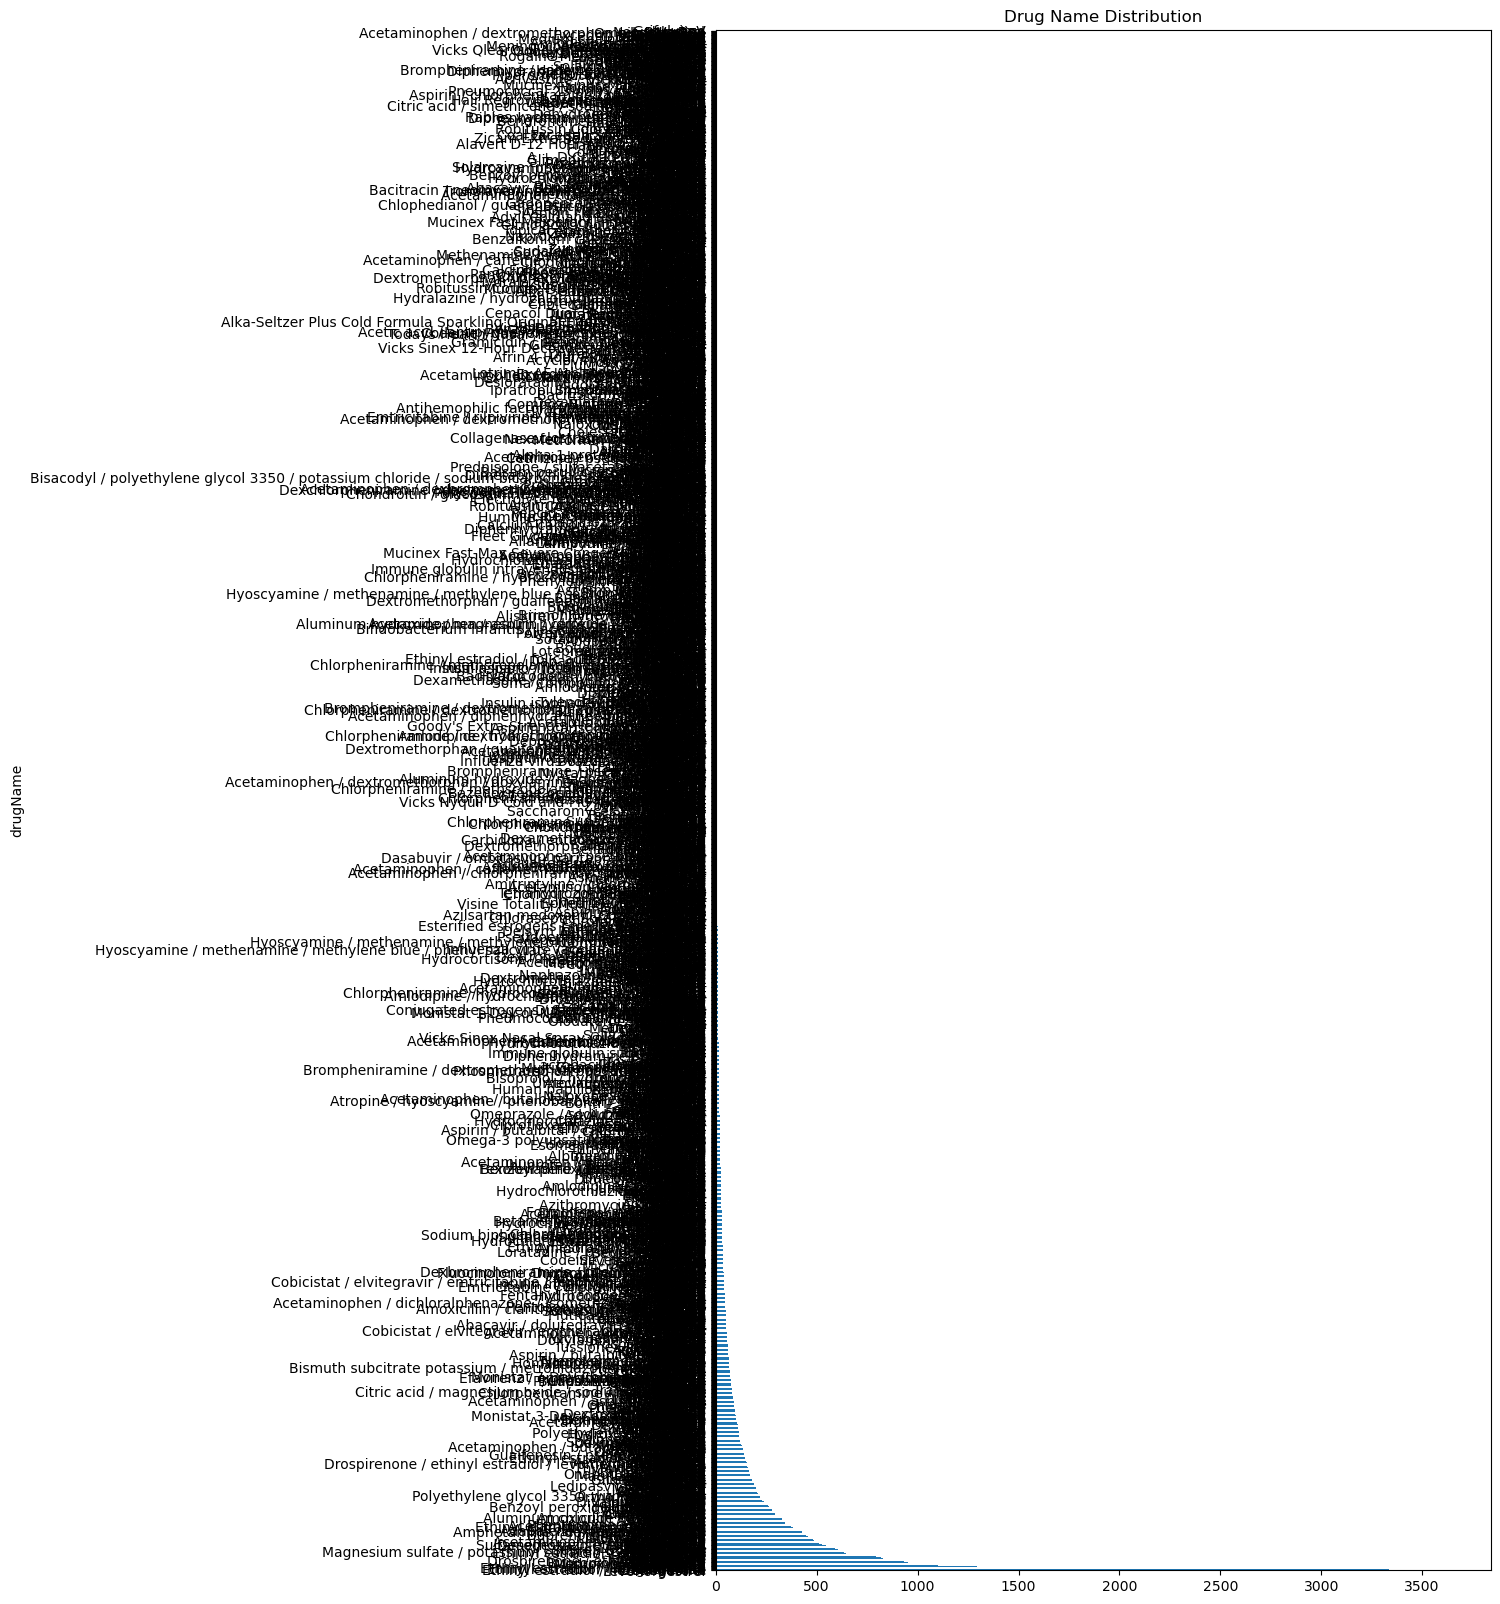

In [10]:
train_df.drugName.value_counts().plot(kind='barh', figsize=(10, 20), title='Drug Name Distribution')

<Axes: title={'center': 'Condition Distribution'}, ylabel='condition'>

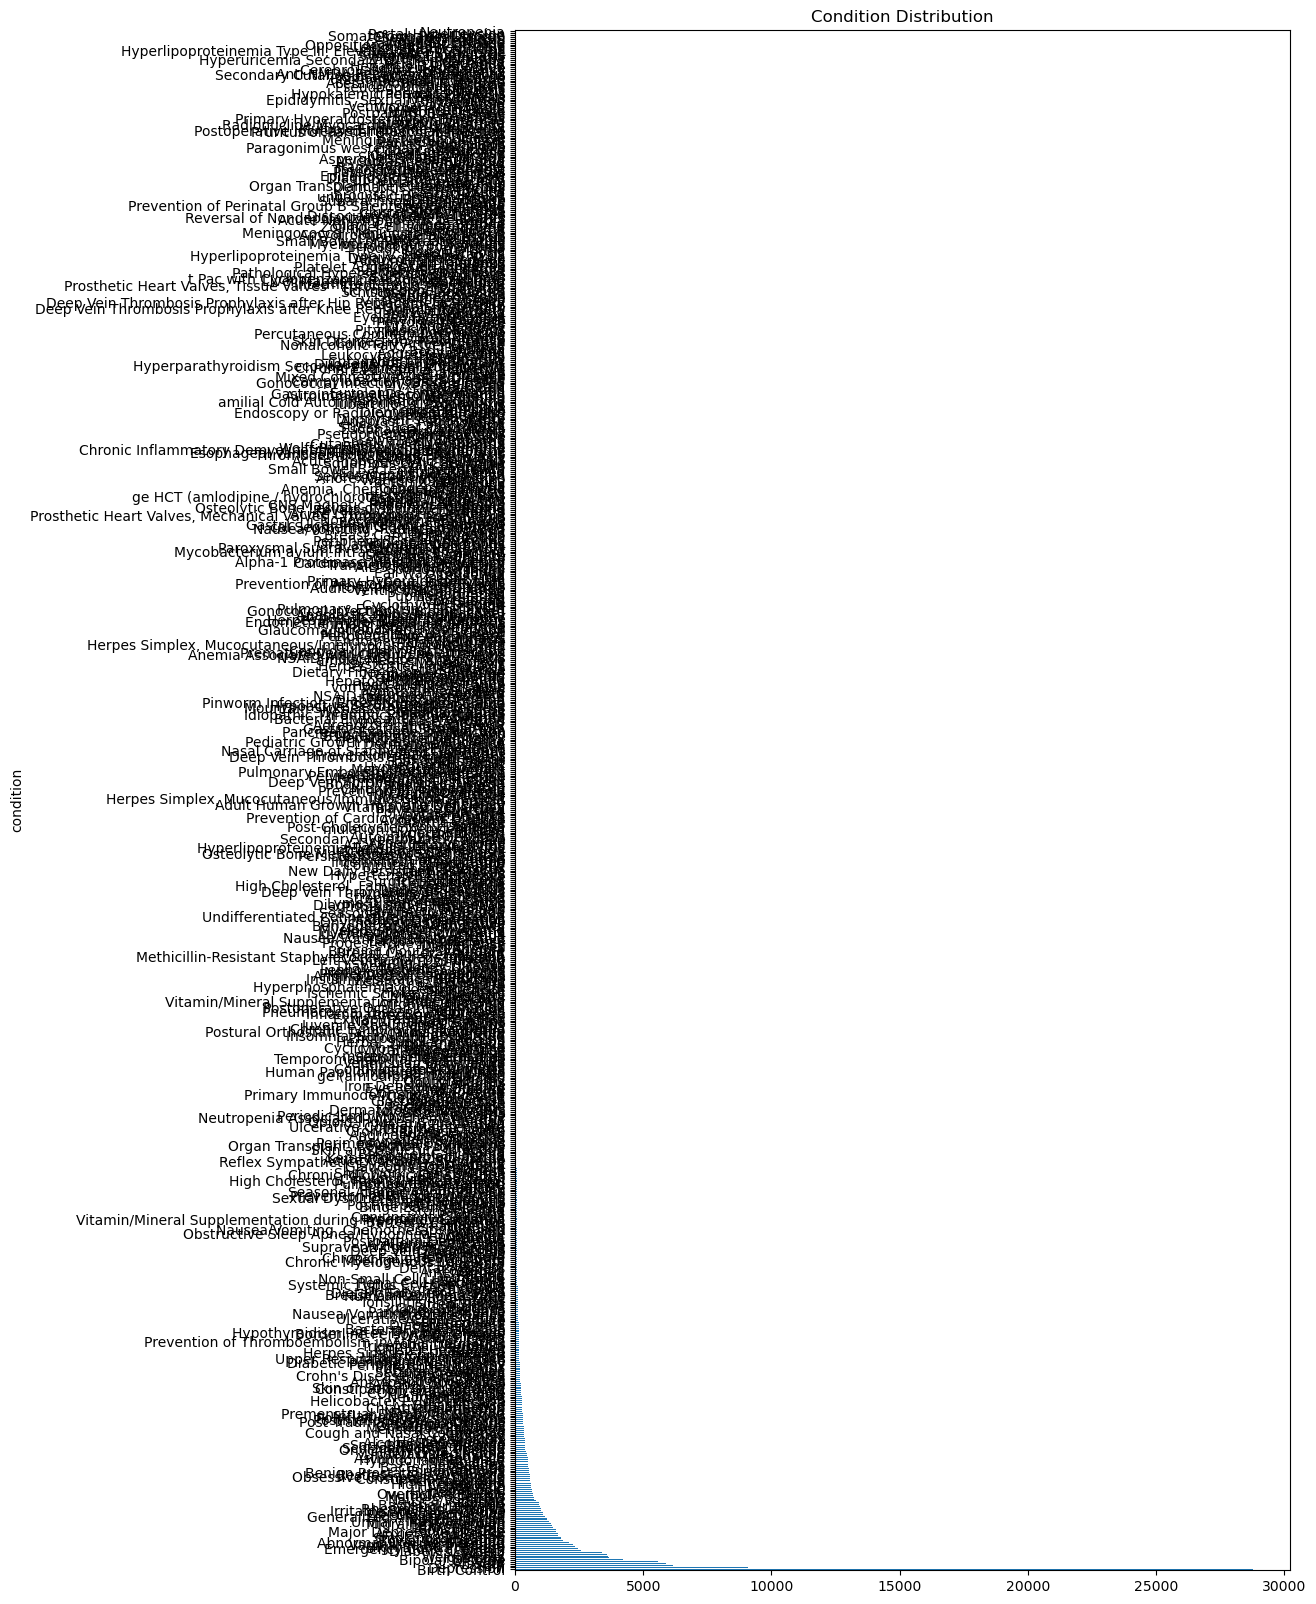

In [11]:
train_df.condition.value_counts().plot(kind='barh', figsize=(10, 20), title='Condition Distribution')

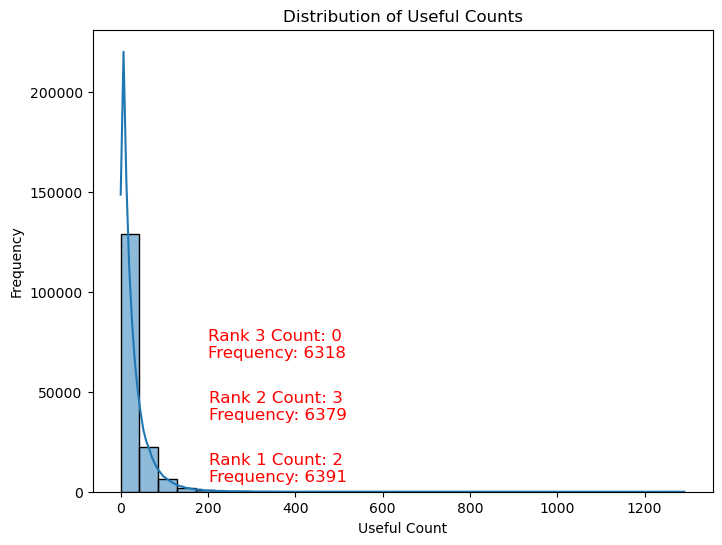

In [12]:
# Visualize the distribution of drug reviews' ratings
plt.figure(figsize=(8, 6))
sns.histplot(train_df['usefulCount'], bins=30, kde=True)
plt.xlabel('Useful Count')
plt.ylabel('Frequency')
plt.title('Distribution of Useful Counts')

# Find the top three most frequent Useful Counts and their frequency counts
most_frequent_counts = train_df['usefulCount'].value_counts().nlargest(3)
top_counts = most_frequent_counts.index
top_counts_freq = most_frequent_counts.values

# Add the top three most frequent Useful Counts and their frequency counts as text to the figure
text_spacing = 31000  # Adjust this value to control the vertical spacing between text lines
for i in range(3):
    x_pos = top_counts[i] + 200
    y_pos = 5000 + i * text_spacing
    text = f'Rank {i+1} Count: {top_counts[i]}\nFrequency: {top_counts_freq[i]}'
    plt.text(x_pos, y_pos, text, fontsize=12, color='red')

plt.show()

Q: count 0 is 6318? how to interpret it?

A: Limited Impact: The review may not have provided significant value or information to other users. It might be a less-detailed or less-informative review.

Reviewer's Intent: Some users may not actively seek or expect to receive "useful" votes on their reviews. They may simply be sharing their experiences or opinions without aiming for high "usefulCount" numbers.

leading our analysis direction to focus on text analysis?

In [13]:
# Group the data by 'condition' and 'drugName', calculate the average rating, and count the reviews
condition_drug_stats = train_df.groupby(['condition', 'drugName']).agg({'rating': 'mean', 'review': 'count'}).reset_index()

# Sort by condition and review count, and select the top 5 drugs for each condition
top5_drugs_by_condition = condition_drug_stats.sort_values(['condition', 'review'], ascending=[True, False]).groupby('condition').head(5)

# Count the occurrences of each condition in the dataset
condition_counts = train_df['condition'].value_counts()

# Select the top three conditions with the highest counts
top3_conditions = condition_counts.index[:3]

# Group by 'condition' and print the top 5 drugs, their counts, and average ratings for the top 3 conditions
for condition in top3_conditions:
    condition_data = top5_drugs_by_condition[top5_drugs_by_condition['condition'] == condition]
    print(f"Condition: {condition}")
    for _, row in condition_data.iterrows():
        print(f"  Drug: {row['drugName']} - Count: {row['review']} - Average Rating: {row['rating']:.2f}")
    print()


Condition: Birth Control
  Drug: Etonogestrel - Count: 3314 - Average Rating: 5.81
  Drug: Ethinyl estradiol / norethindrone - Count: 2337 - Average Rating: 5.66
  Drug: Nexplanon - Count: 2149 - Average Rating: 5.68
  Drug: Levonorgestrel - Count: 2129 - Average Rating: 7.06
  Drug: Ethinyl estradiol / levonorgestrel - Count: 1600 - Average Rating: 5.90

Condition: Depression
  Drug: Bupropion - Count: 549 - Average Rating: 7.36
  Drug: Sertraline - Count: 459 - Average Rating: 7.17
  Drug: Venlafaxine - Count: 437 - Average Rating: 6.48
  Drug: Pristiq - Count: 418 - Average Rating: 7.19
  Drug: Desvenlafaxine - Count: 414 - Average Rating: 7.24

Condition: Pain
  Drug: Tramadol - Count: 357 - Average Rating: 6.51
  Drug: Acetaminophen / hydrocodone - Count: 332 - Average Rating: 7.98
  Drug: Oxycodone - Count: 281 - Average Rating: 8.86
  Drug: Acetaminophen / oxycodone - Count: 249 - Average Rating: 8.55
  Drug: Tapentadol - Count: 216 - Average Rating: 6.33



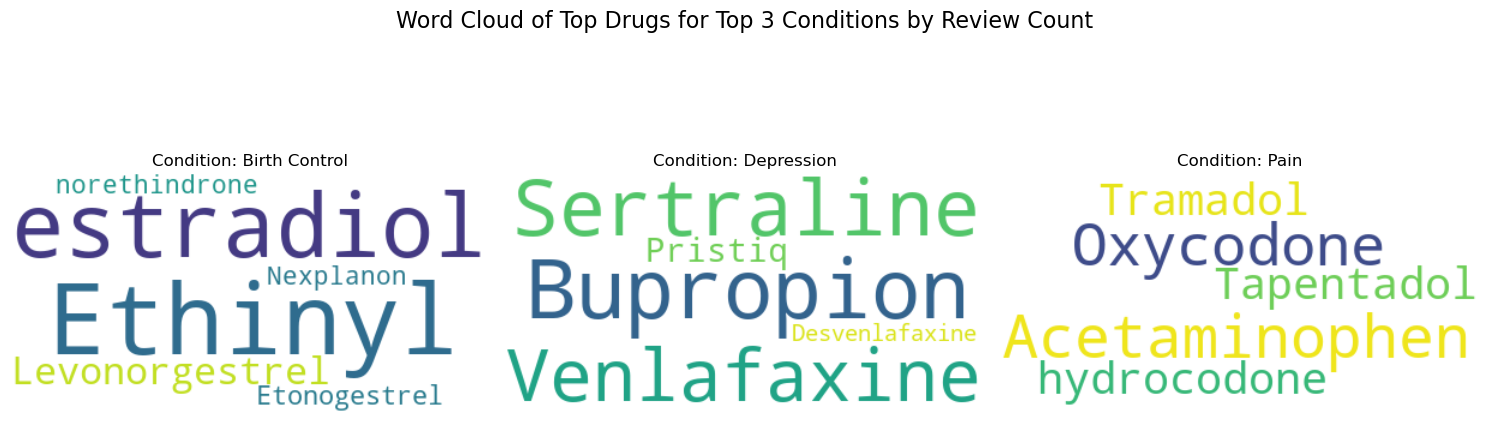

In [14]:
# Create a word cloud for the top drugs for each of the top 3 conditions
plt.figure(figsize=(15, 5))
for i, condition in enumerate(top3_conditions, 1):
    plt.subplot(1, 3, i)
    
    # Filter data for the current condition
    condition_data = top5_drugs_by_condition[top5_drugs_by_condition['condition'] == condition]
    
    # Get the top drugs for the current condition
    top_drugs = condition_data['drugName']
    
    # Create a word cloud for the top drugs
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(' '.join(top_drugs))
    
    # Display the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Condition: {condition}')
    plt.axis('off')

plt.suptitle('Word Cloud of Top Drugs for Top 3 Conditions by Review Count', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


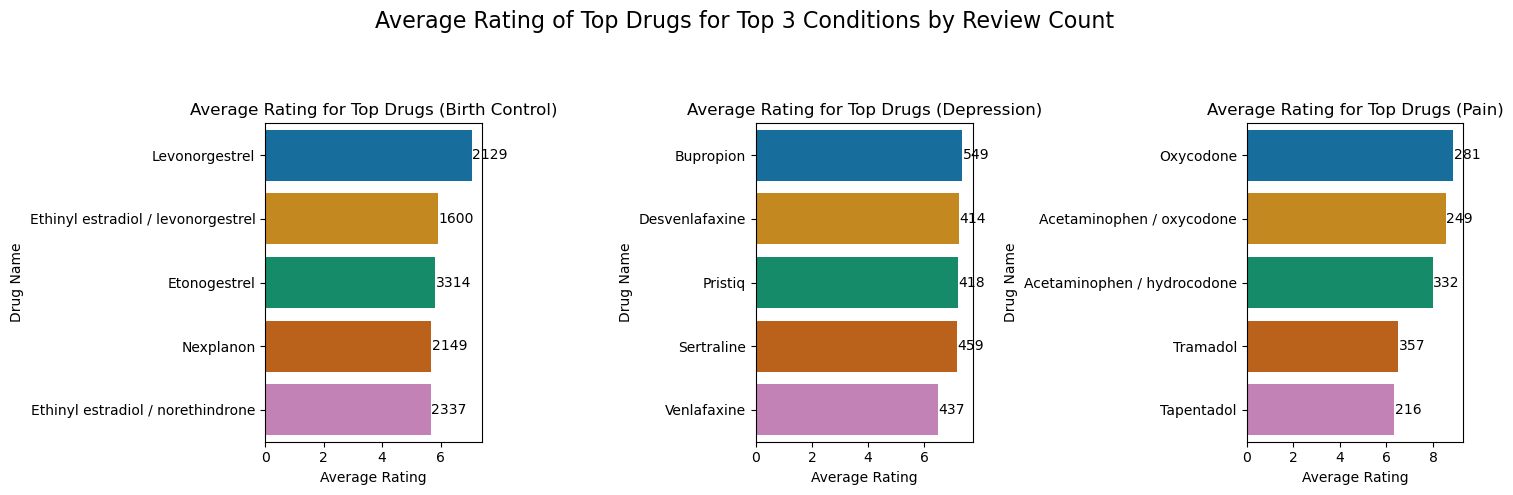

In [15]:
# Create a color palette with distinct colors
colors = sns.color_palette("colorblind", n_colors=15)

# Create a bar chart for average ratings of the top drugs for the top 3 conditions
plt.figure(figsize=(15, 5))
for i, condition in enumerate(top3_conditions, 1):
    plt.subplot(1, 3, i)
    
    # Filter data for the current condition
    condition_data = top5_drugs_by_condition[top5_drugs_by_condition['condition'] == condition]
    
    # Order drugs based on average rating
    condition_data = condition_data.sort_values(by='rating', ascending=False)
    
    # Create a bar chart for average ratings with unique colors for each drug
    bar_plot = sns.barplot(data=condition_data, x='rating', y='drugName', palette=colors)
    
    # Add the count as text at the end of each bar
    for index, row in enumerate(condition_data.iterrows(), start=1):
        bar_plot.text(row[1]['rating'] + 0.02, index - 1, f'{row[1]["review"]}', va='center', fontsize=10)
    
    plt.xlabel('Average Rating')
    plt.ylabel('Drug Name')
    plt.title(f'Average Rating for Top Drugs ({condition})')
    plt.tight_layout()

plt.suptitle('Average Rating of Top Drugs for Top 3 Conditions by Review Count', fontsize=16)
plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.9))
plt.show()


<Axes: title={'center': 'Rating Density Plot'}, ylabel='Density'>

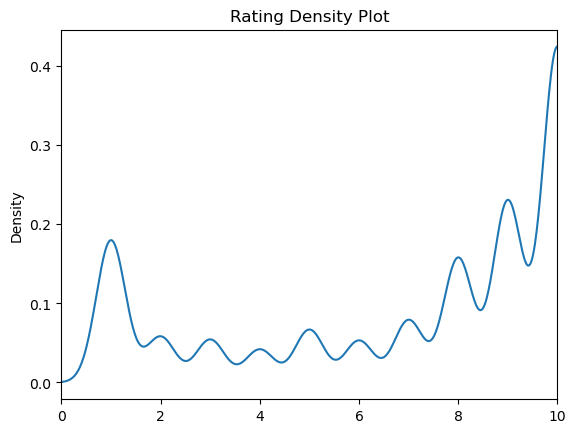

In [16]:
train_df.rating.plot(kind='density', title='Rating Density Plot', xlabel='Value', ylabel='Density', xlim=(0, 10))

<Axes: title={'center': 'Rating Density Plot for rows with missing condition values'}, ylabel='Density'>

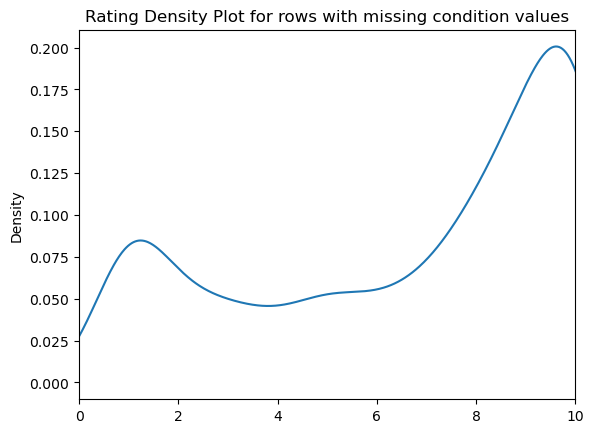

In [17]:
# Check out rating distribution for rows with missing condition values
#print(train_df[train_df.condition.isna()].rating.value_counts())

train_df[train_df.condition.isna()].rating.plot(
    kind='density',
    title='Rating Density Plot for rows with missing condition values',
    xlabel='Value', ylabel='Density', xlim=(0, 10)
)

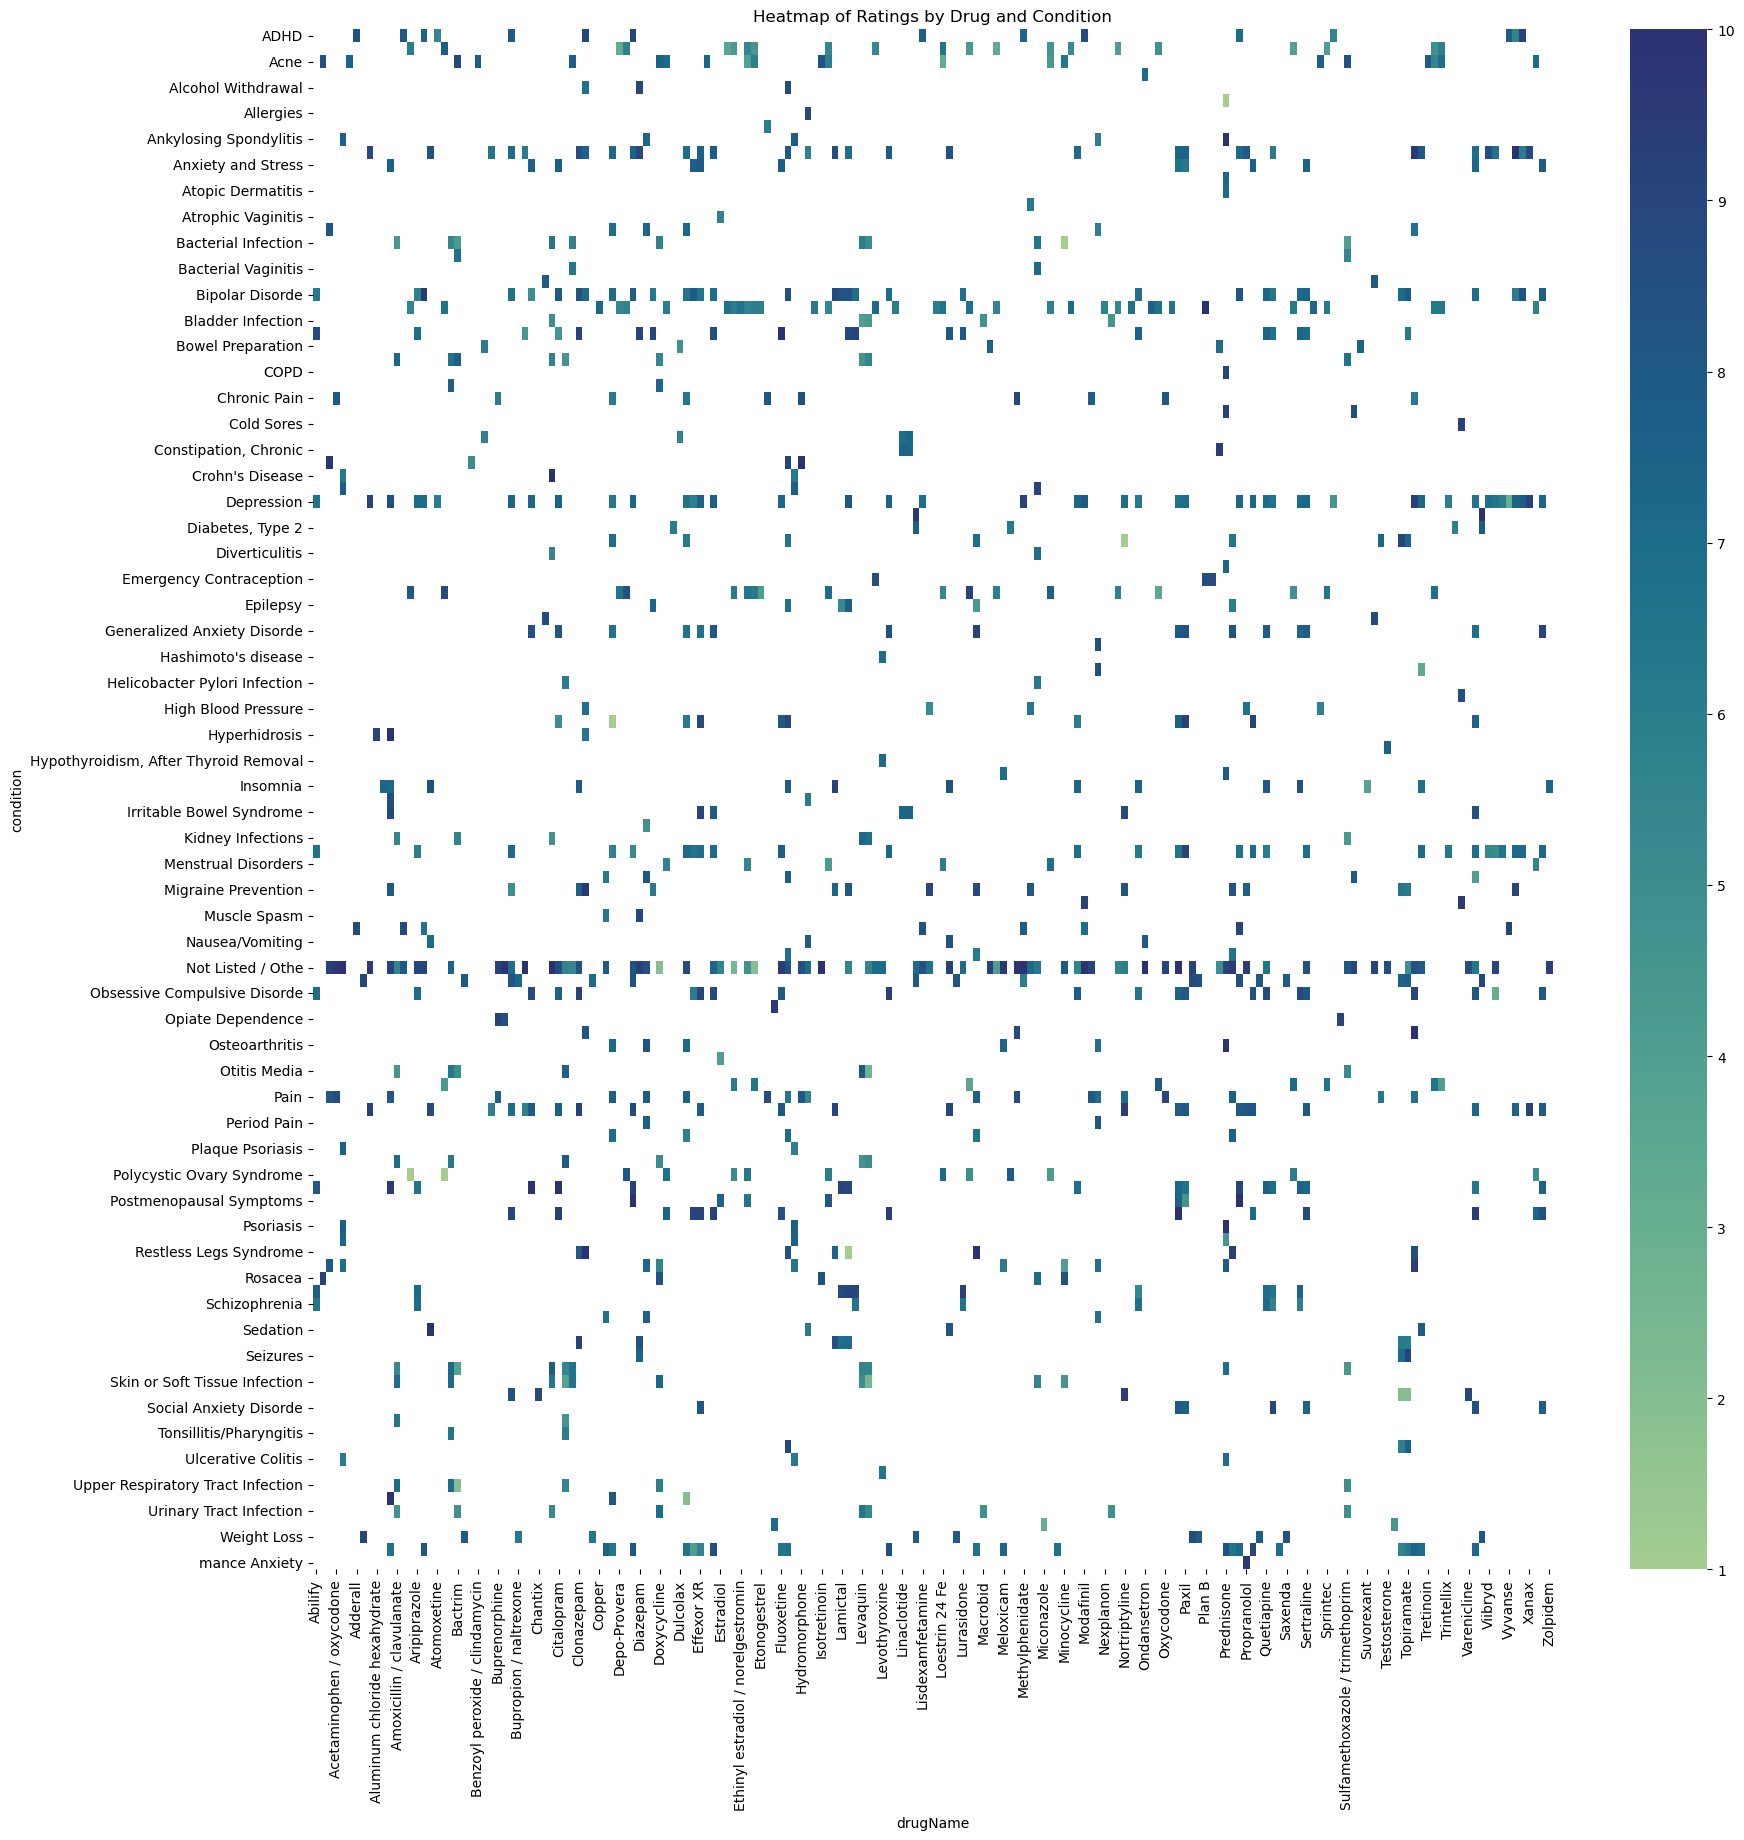

In [18]:
# Heatmap of Ratings by drugName and condition

freq_drugName = train_df.drugName.value_counts()[train_df.drugName.value_counts().ge(200)].index
freq_condition = train_df.condition.value_counts()[train_df.condition.value_counts().ge(100)].index

agg_df = train_df[train_df.drugName.isin(freq_drugName) & train_df.condition.isin(freq_condition)].groupby(['drugName', 'condition']).rating.mean().reset_index()
pivot_df = pd.pivot_table(agg_df, values='rating', index='condition', columns='drugName')

plt.figure(figsize=(20, 20))
sns.heatmap(pivot_df, annot=False, fmt='.0f', cbar=True, cmap='crest')
plt.title('Heatmap of Ratings by Drug and Condition')
plt.xlabel('drugName')
plt.ylabel('condition')
plt.show()

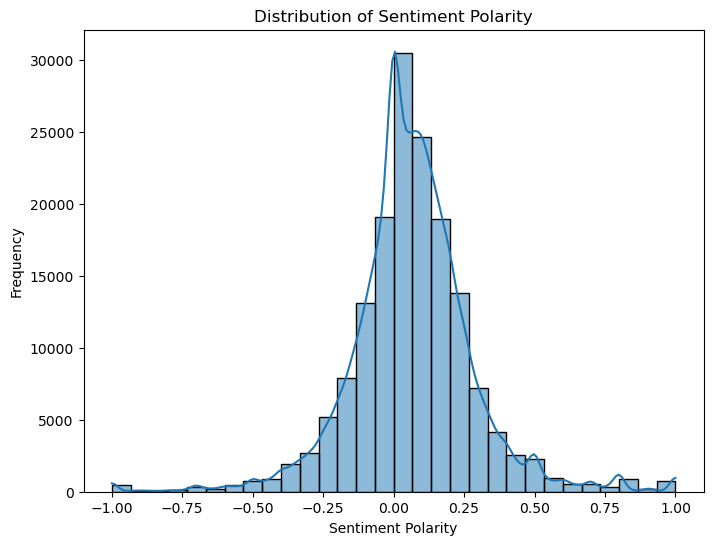

In [19]:
# Create a function to get sentiment polarity
def get_sentiment_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the review text
train_df['sentiment_polarity']=train_df['review'].apply(get_sentiment_polarity)

# Visualize the sentiment polarity distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_df['sentiment_polarity'], bins=30, kde=True)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarity')
plt.show()

## 3 - Extract Sample Subset of Train Data

Extract a preliminary evaluation to select a model before committing to the more time-consuming process of training and hyperparameter tuning on the full dataset.

For statistical significance, a stratified random sampling will be implemented to extract 20% of the training data as the sample subset.

Since the supervised learning task is to predict the `rating`, the stratification will be done by `rating`.

In [20]:
# 
X_train = train_df.iloc[:, 1:].drop('rating', axis=1)
y_train = train_df.rating

print(f'X_train shape: {X_train.shape}')
print(f'X_train columns: {X_train.columns}')
print('')
print(f'y_train shape: {y_train.shape}')

X_train shape: (161297, 6)
X_train columns: Index(['drugName', 'condition', 'review', 'date', 'usefulCount',
       'sentiment_polarity'],
      dtype='object')

y_train shape: (161297,)


In [21]:
# Sample 20% of the training data for preliminary model evaluation, stratified by y_train
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, stratify=y_train, test_size=0.8, random_state=42)

print(f'X_sample shape: {X_sample.shape}')
print(f'X_sample columns: {X_sample.columns}')
print('')
print(f'y_sample shape: {y_sample.shape}')

X_sample shape: (32259, 6)
X_sample columns: Index(['drugName', 'condition', 'review', 'date', 'usefulCount',
       'sentiment_polarity'],
      dtype='object')

y_sample shape: (32259,)


In [22]:
# Save the sample subset of training data to disk
#X_sample.to_csv('./data/lewtun-drug-reviews/X_sample.csv', index=False)
#y_sample.to_csv('./data/lewtun-drug-reviews/y_sample.csv', index=False)

## 4 - Text Preprocessing - PIPELINE